# Capstone Project - The Battle of Neighborhoods
## 1. Introduction

Below is the brief discussion of the project that I want to conduct

The cinema company wants to expand their business and open more movie theater in Ho Chi Minh city. The business stakeholder wants know Which location you will recommend in Ho Chi Minh city to open a movie theater in order to attract as many customers as possible.

An understanding of existing location will help making the decision and after discussion with the management team, strategic planning, data scientist teams came out with the following hypothesis of the popular movie theater location.

* Places surrounded by shopping street, hotel, entertainment spots.
* Near big road, does not locate in small roads.

Then, after analyzing the current cinema location data, I will maek recommendation on the next potential location for a new movie theater.

## 2. Data
   *  Use the list of movie theater taken from the website
   *  Use Foursquare data to explore the surrounding area characteristics

In [1]:
import pandas as pd
import numpy as np
import json # library to handle JSON files


import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt

In [11]:
cinema = pd.read_csv("Data/Data.csv")
cinema


,Address,Latitude,Longitude
0,469 Nguyen Huu Tho,10.740905,106.702379
1,1058 Nguyen Van Linh,10.730192,106.703834
2,3 Nguyen Luong Bang,10.729645,106.721671
3,271 Nguyen Trai,10.763787,106.687485
4,235 Nguyen Van Cu,10.764295,106.682353
5,116 Nguyen Du,10.773259,106.692918
6,246 Nguyen Hong Dao,10.790806,106.640668
7,968 Duong ba thang hai,10.763119,106.657070
8,212 Ly Chinh Thang,10.780556,106.682579
9,12 Quoc Huong,10.801713,106.732965


To explore the surrounding facilities of each location, I use the FourSquare API

In [8]:
# define Foursquare Credentials and Version
CLIENT_ID = 'LM2QESNXA3LD2SWAQWW4ODK2KAXEMTIGNU5CQ0WK4VQKHHVN' # your Foursquare ID
CLIENT_SECRET = '1KGIHAR0GPAHDBOORGAQ11DGIKUFFRVYB05F4I1KFWBH4T1K' # your Foursquare Secret
VERSION = '20191229' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LM2QESNXA3LD2SWAQWW4ODK2KAXEMTIGNU5CQ0WK4VQKHHVN
CLIENT_SECRET:1KGIHAR0GPAHDBOORGAQ11DGIKUFFRVYB05F4I1KFWBH4T1K


In [12]:
# Get the top 10 venues that are within a radius of 500 meters.
radius = 500
LIMIT = 20

venues = []

for lat, long, neighborhood in zip(cinema['Latitude'], cinema['Longitude'], cinema['Address']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
      
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [21]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Address', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head(10)

(186, 7)


,Address,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,469 Nguyen Huu Tho,10.740905,106.702379,Terrace Sunrise City,10.738890,106.700115,Café
1,469 Nguyen Huu Tho,10.740905,106.702379,Phuc Long Lotte Mart Q7,10.740448,106.701524,Café
2,469 Nguyen Huu Tho,10.740905,106.702379,Pizza Hut,10.741519,106.701772,Pizza Place
3,469 Nguyen Huu Tho,10.740905,106.702379,Cơm Tấm Bụi Sài Gòn,10.739967,106.703132,Vietnamese Restaurant
4,469 Nguyen Huu Tho,10.740905,106.702379,Lotte Cinema Nam Sài Gòn,10.740783,106.701163,Multiplex
5,469 Nguyen Huu Tho,10.740905,106.702379,Cơm Tấm Nhớ,10.740130,106.702711,Vietnamese Restaurant
6,469 Nguyen Huu Tho,10.740905,106.702379,Com Tam Bui Saigon,10.740038,106.703006,Vietnamese Restaurant
7,469 Nguyen Huu Tho,10.740905,106.702379,SUSHI 88 . VN,10.740535,106.698670,Japanese Restaurant
8,469 Nguyen Huu Tho,10.740905,106.702379,Bún Bò Huế Chánh Gốc,10.745109,106.703047,Noodle House
9,469 Nguyen Huu Tho,10.740905,106.702379,Lotte Mart,10.740518,106.701622,Shopping Mall



## 3. Exploratory analysis
Number of Venue associated with each location:

After retrieving the list of surrounding locations. I will see how many locations were returned for each address

In [15]:
b=venues_df.groupby(["Address"]).count()
b=b.iloc[:,0:1]
b

,Latitude
Address,
1058 Nguyen Van Linh,20
116 Nguyen Du,20
12 Quoc Huong,20
212 Ly Chinh Thang,20
235 Nguyen Van Cu,20
246 Nguyen Hong Dao,8
271 Nguyen Trai,20
3 Nguyen Luong Bang,20
469 Nguyen Huu Tho,15



* List of category

Let's see what kind of Venue categories we have in the database

In [16]:
venues_df['VenueCategory'].unique()[:50]

array(['Café', 'Pizza Place', 'Vietnamese Restaurant', 'Multiplex',
       'Japanese Restaurant', 'Noodle House', 'Shopping Mall',
       'Restaurant', 'Fast Food Restaurant', 'Asian Restaurant',
       'Bubble Tea Shop', 'Coffee Shop', 'Indian Restaurant',
       'Korean Restaurant', 'Hotel', 'Supermarket', 'Bakery', 'Gastropub',
       'Gym / Fitness Center', 'Udon Restaurant', 'Bar', 'Dessert Shop',
       'BBQ Joint', 'Bistro', 'Steakhouse',
       'Residential Building (Apartment / Condo)', 'Sushi Restaurant',
       'Clothing Store', 'Bed & Breakfast', 'Seafood Restaurant',
       'Hostel', 'Beer Bar', 'Middle Eastern Restaurant', 'Spa',
       'Vegetarian / Vegan Restaurant', 'Food', 'Arts & Crafts Store',
       'Food Truck', 'Lounge', 'Bookstore', 'Hotel Bar', 'Sandwich Place',
       'Park', 'Nightclub', 'Shoe Store', 'Cajun / Creole Restaurant',
       'Juice Bar', 'National Park', 'Food Court', 'Shopping Plaza'],
      dtype=object)

In [17]:
# one hot encoding
onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Address'] = venues_df['Address'] 
a = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[a]
onehot.head()

,Address,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Bistro,Bookstore,...,Sports Club,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Tennis Stadium,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,469 Nguyen Huu Tho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,469 Nguyen Huu Tho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,469 Nguyen Huu Tho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,469 Nguyen Huu Tho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,469 Nguyen Huu Tho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Which venue cateogry appears the most in the dataset

To count the frequency of each category appeared in the dataset, I wil generate the mena of each category for each store address

In [18]:
a=onehot.sum().reset_index()
a.columns=['category','count']
a=a.iloc[1:,:]
a=a.sort_values(by='count', ascending=False).reset_index()
a=a.iloc[:,1:]
a.head(15)

,category,count
0,Café,23
1,Vietnamese Restaurant,12
2,Hotel,12
3,Coffee Shop,10
4,Noodle House,5
5,BBQ Joint,5
6,Multiplex,5
7,Shopping Mall,5
8,Seafood Restaurant,4
9,Gym / Fitness Center,4


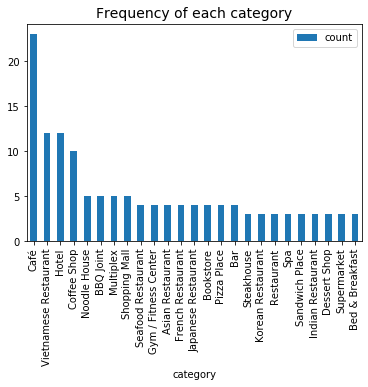

In [19]:
# Plot the result
a1=a.head(25)
a1.plot.bar(x='category',y='count')
plt.title('Frequency of each category',fontsize = 14)
plt.show()

In [20]:

venues_df.groupby('Address').VenueCategory.agg([('VenueCategory', ', '.join)]).reset_index()

,Address,VenueCategory
0,1058 Nguyen Van Linh,"Multiplex, Bubble Tea Shop, Coffee Shop, India..."
1,116 Nguyen Du,"Sandwich Place, Park, Nightclub, Shoe Store, H..."
2,12 Quoc Huong,"Mexican Restaurant, French Restaurant, Superma..."
3,212 Ly Chinh Thang,"Café, Restaurant, Café, French Restaurant, Caf..."
4,235 Nguyen Van Cu,"Hotel, Food, Café, Seafood Restaurant, Arts & ..."
5,246 Nguyen Hong Dao,"Shopping Plaza, Movie Theater, Café, Restauran..."
6,271 Nguyen Trai,"Bed & Breakfast, Noodle House, Dessert Shop, C..."
7,3 Nguyen Luong Bang,"BBQ Joint, Coffee Shop, Bistro, Hotel, Gym / F..."
8,469 Nguyen Huu Tho,"Café, Café, Pizza Place, Vietnamese Restaurant..."
9,968 Duong ba thang hai,"Chinese Restaurant, BBQ Joint, Asian Restauran..."


Most of the surrounding facilities belong to restaurants, coffee shop and cafe catogories, which include Cafe/Coffee shop, Vietnamese restaurant, Hotel.

In each branch, there is at least 1 cafe/coffee shop or Vietnamese restaurant